<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [2]:
df = pd.read_csv("winequality-red.csv", sep=';')
df.quality = df.quality.apply(lambda x: 1 if x > 5 else 0)
df_train = df.sample(int(0.8 * df.shape[0]))
df_cont = df[~df.isin(df_train)].dropna()
df.shape, df_train.shape, df_cont.shape

((1599, 12), (1279, 12), (320, 12))

In [3]:
X_train = df_train.drop('quality', axis=1).values
y_train = df_train.quality
X_cont = df_cont.drop('quality', axis=1).values
y_cont = df_cont.quality

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [4]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Verdana'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


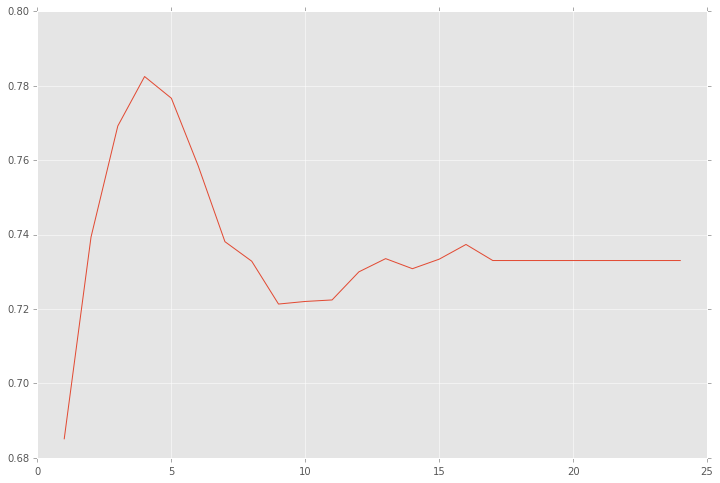

In [5]:
a = []
b = []
for depth in xrange(1, 25, 1):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    cvs = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5).mean()
    a.append(depth)
    b.append(cvs)
plt.plot(a, b)

In [6]:
model = DecisionTreeClassifier(random_state=42)
train_score, test_score = validation_curve(model, X_train, y_train, 'max_depth', range(1, 25), n_jobs=1, cv=5, scoring='roc_auc')

In [7]:
train_mean = train_score.mean(axis=1)
train_std = train_score.std(axis=1)
test_mean = test_score.mean(axis=1)
test_std = test_score.std(axis=1)

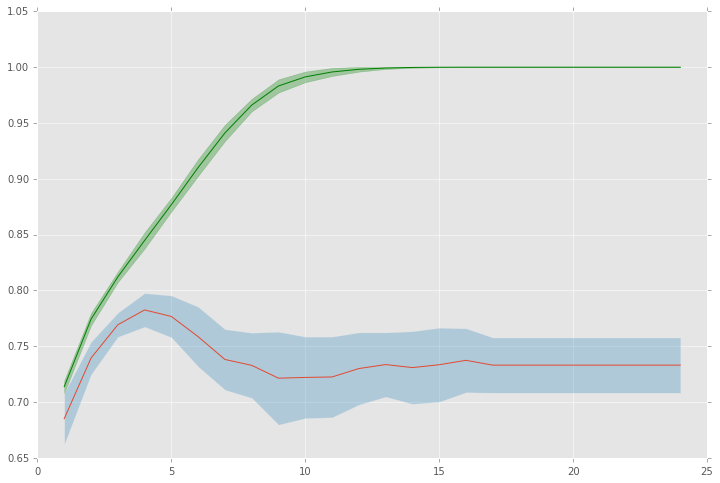

In [8]:
d = range(1, 25)
plt.plot(d, train_mean, color='green')
plt.plot(d, test_mean)
plt.fill_between(d, train_mean-train_std, train_mean+train_std, color='green', alpha=0.3)
plt.fill_between(d, test_mean-test_std, test_mean+test_std, alpha=0.3)

Значение глубины можно взять равным 5.

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [9]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [10]:
prop = sorted(zip(df.columns, clf.feature_importances_), key=(lambda x: x[1]), reverse=True)
for s, p in prop:
    print "{0}: {1:.3f}".format(s, p)

alcohol: 0.516
sulphates: 0.170
total sulfur dioxide: 0.116
volatile acidity: 0.062
pH: 0.055
fixed acidity: 0.043
free sulfur dioxide: 0.019
citric acid: 0.013
residual sugar: 0.007
chlorides: 0.000
density: 0.000


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

In [11]:
from sklearn.metrics import accuracy_score, average_precision_score

In [12]:
y_pred = clf.predict(X_cont)  # predict for control sample
y_pred_probs = clf.predict_proba(X_cont)
y_tpred = clf.predict(X_train)  # predict for training sample
y_tpred_probs = clf.predict_proba(X_train)

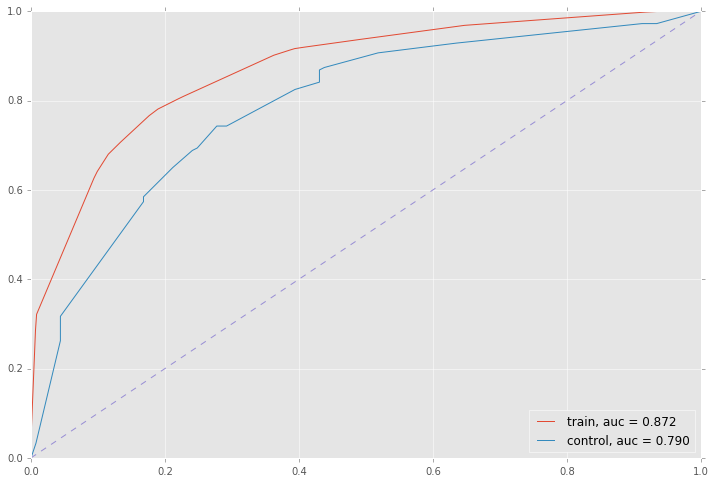

In [13]:
from sklearn.metrics import roc_curve, auc

fpr_t, tpr_t, _ = roc_curve(y_train, y_tpred_probs[:,1])
roc_auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label='train, auc = %.3f' % roc_auc_t)

fpr, tpr, _ = roc_curve(y_cont, y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='control, auc = %.3f' % roc_auc)

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

In [14]:
p = clf.predict_proba(X_train)

In [15]:
accuracy_score(y_train, y_tpred), average_precision_score(np.c_[1 - y_train, y_train], p)

(0.79515246286161068, 0.87469459153282936)

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
rs = 1234

In [22]:
scores_bc = []
idxs_bc = range(10, 110, 10)
for n_est in idxs_bc:
    tr = DecisionTreeClassifier(max_depth=5, random_state=rs)
    bc = BaggingClassifier(base_estimator=tr, n_estimators=n_est, random_state=rs)
    bc.fit(X_train, y_train)
    scores_bc.append(average_precision_score(y_train, bc.predict_proba(X_train)[:,1]))

In [58]:
scores_rf = []
idxs_rf = range(10, 110, 10)
for n_est in idxs_rf:
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=5, criterion='gini',
                                random_state=rs, max_features=None)
    rf.fit(X_train, y_train)
    scores_rf.append(average_precision_score(y_train, rf.predict_proba(X_train)[:,1]))

In [20]:
print "качество для одного дерева {:.3f}".format(average_precision_score(y_train, y_tpred_probs[:,1]))

качество для одного дерева 0.891


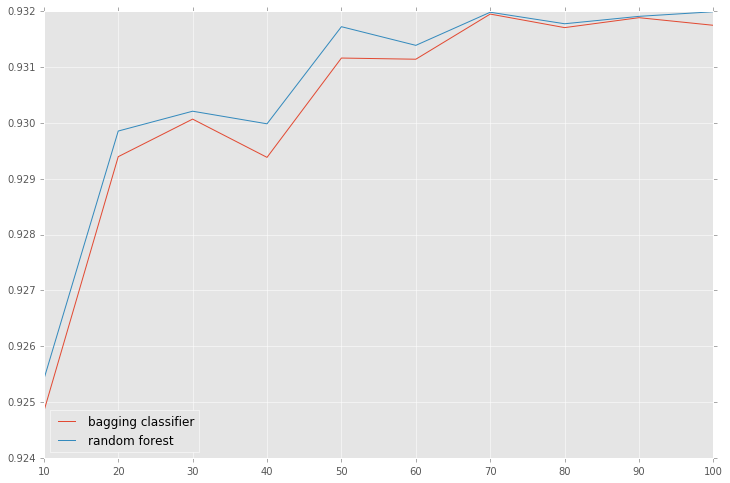

In [41]:
plt.plot(idxs_bc, scores_bc, label='bagging classifier')
plt.plot(idxs_rf, scores_rf, label='random forest')
plt.legend(loc=3)
plt.show()

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

In [54]:
gs = GridSearchCV(RandomForestClassifier(random_state=rs, max_depth=5, max_features=None),
                  param_grid={'n_estimators':range(30, 60, 5),
                             'criterion': ['gini', 'entropy'],},
                  cv=5, scoring=make_scorer(average_precision_score), n_jobs=-1)
gs.fit(X_train, y_train)
print gs.best_params_

{'n_estimators': 35, 'criterion': 'gini'}


In [55]:
fclf = gs.best_estimator_
fclf.fit(X_train, y_train)
y_cpred = fclf.predict(X_cont)

In [61]:
cross_val_score(fclf, X_cont, y_cont, cv=5).mean()

0.75639499389499387

In [62]:
print "accuracy: {0:.3f},\naverage precision: {1:.3f}".format(accuracy_score(y_cont, y_cpred),
                                          average_precision_score(y_cont, fclf.predict_proba(X_cont)[:,1]))

accuracy: 0.756,
average precision: 0.864
